## NB of the functions to transform JA's 2D event images are trasnformed into graphs

In [22]:
import numpy as np
import tables as tb
import pandas as pd
from time import time
import torch
import sys
from glob import glob

sys.path.append('/home/usc/ie/mpm/NEXT_graphs')
from NEXT_graphNN.utils.data_loader import graphData

In [44]:
path = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/pressure_topology/5bar/2d_data/'

In [45]:
data = np.load(path + '5bar_0nubb_s0mm_w10mm.npz')

In [46]:
[f for f in data.files]

['x', 'y', 'z', 'id', 'xlabel', 'zlabel']

In [5]:
x, y, z, id = data['x'], data['y'], data['z'], data['id']
xlabel, zlabel = list(data['xlabel']), list(data['zlabel'])

* **x**: parece que contiene las imágenes 31x31 (en este caso), para N eventos, y 6 cualidades q son suma de E y media de Z en las 3 proyecciones (entonces no es media de z, es media de la coordenada restante)
* **z**: contiene tb lo mismo, pero las cualidades son media de segclass (?) y maximo de extremo, para las 3 proyecciones

* **zlabel y xlabel**: contienen información de que son las 6 cualidades tanto para x como para z

* **id**: contiene el filenumber y el dataset_id

* **y**: contiene la etiqueta del evento

## El código este ya está para poner en un script prácticamente, sólo falta lo de que no me coinciden las imágenes...

In [1]:
import os
import sys
import gzip
import torch

import numpy  as np
import pandas as pd

from time import time
from glob import glob

sys.path.append(os.getenv('HOME') + '/NEXT_graphs')
from NEXT_graphNN.utils.data_loader import graphData


path = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/pressure_topology/5bar/2d_data/'
compression = False
fileout = path + '5bar_s0mm_w10mm_graph.pt'

data_paths = glob(path + '*')

dataset = []
for f in data_paths:
    print(f.split('/')[-1])
    data = np.load(f)
    x, y, z, id = data['x'], data['y'], data['z'], data['id']
    xlabel, zlabel = list(data['xlabel']), list(data['zlabel'])
    del data
    t = time()

    
    for n in range(x.shape[1]):
        coords = x[0][n].nonzero()
        values = (x[0][n][coords], x[1][n][coords])

        #si coincidieran, podría ponerle su propio coords, pero veo que no...
        #hecho así hay varios pixeles con valor de segmentación nulo pero no de energía o de z..
        segclass = (z[0][n][coords], z[1][n][coords])
        label = y[n]
        fnum, dat_id = id[n][0], id[n][1]

        dat_dic = {'x':coords[0], 
                'y':coords[1], 
                'energy':values[0], 
                'z_mean':values[1], 
                'seg_mean':segclass[0], 
                'seg_max':segclass[1].astype('int32'), 
                'binclass':label, 
                'fnum':fnum, 
                'dataset_id':dat_id}

        event = pd.DataFrame(dat_dic)
        graph_data = graphData(event, 
                            dat_id, 
                            feature_n = ['energy', 'z_mean'], 
                            label_n = ['seg_mean', 'seg_max'], 
                            norm_features = False, 
                            max_distance = np.sqrt(2), 
                            ener_name = 'energy', 
                            coord_names = ['x', 'y'], 
                            directed = False, 
                            fully_connected = False, 
                            simplify_segclass = False, 
                            torch_dtype = torch.float)

        if graph_data.edge_index.numel() == 0:
            continue
        graph_data.fnum = fnum
        dataset.append(graph_data)
    print(time() - t)


if compression:
    fileout += '.gz'
    with gzip.open(fileout, 'wb') as fout:
        torch.save(dataset, fout)
else: torch.save(dataset, fileout)
    

5bar_0nubb_s0mm_w10mm.npz
1321.3235130310059
5bar_1eroi_s0mm_w10mm.npz
1894.3122472763062


### Y para leer esos datos:

In [47]:
# COMPRESSED
with gzip.open(path + '5bar_s0mm_w10mm_graph_compr.pt.gz', 'rb') as fout:
    cosa2 = torch.load(fout)

# NO COMPRESSED
cosa = torch.load(path + '5bar_s0mm_w10mm_graph_nocompr.pt')

In [80]:
import itertools
import torch
import sys

from NEXT_graphNN.utils.data_loader import edge_index, graphData
from   torch_geometric.data import Data

sys.path.append('/home/usc/ie/mpm/data_labelling')
from utils.grouping_utils import label_event_elements


## CAMBIAR GRAPH DATA PARA EVITAR Q HAGA CLOUDS

## O CAMBIAR ALGO DE CLOUDS PARA EVITAR Q FALLE LO DEL NHITS (voy a pasar porque no me hace bien clouds de mi evento, falla algo en el proceso que me da pereza de ponerme a mirar)

In [ ]:
## con esto podría hacerlo si me diera bien, pero como no me va, lo dejo aqui por si necesito recordarlo pero no lo uso

# event_cloud = label_event_elements(event, 
#                          np.sqrt(2), 
#                          coords = ['x', 'y'], 
#                          identifyer = 'dataset_id', 
#                          ene_label = 'energy', 
#                          seg_label = 'seg_max',
#                          beersh_dict =  {1:1, 2:2, 3:3, 4:1, 5:2, 6:3, 7:7}, 
#                          blob_class = [3, 6])

In [90]:
def graphData(event, 
              data_id, 
              feature_n = ['energy', 'nhits'], 
              label_n = ['segclass'], 
              norm_features = True, 
              max_distance = np.sqrt(3), 
              ener_name = 'energy', 
              coord_names = ['xbin', 'ybin', 'zbin'], 
              directed = False, 
              fully_connected = False, 
              simplify_segclass = False, 
              torch_dtype = torch.float):
    '''
    Creates for an event the Data PyTorch geometric object with the edges, edge features (distances, 'gradient' with normalized energy), edge weights (inverse of distance),
    node features (normalized energy and normalized number of hits per voxel), label, number of nodes, coords, dataset ID and binclass.
    '''
    #a bit hard coded this part but no worries for now
    def get_cloud_ener_nhits(event, norm_features = True):
        cloud_feat = event.merge(event.groupby('cloud').nhits.sum().rename('cloud_nhits'), left_on = 'cloud', how = 'left', right_index = True)[['cloud_ener', 'cloud_nhits']]
        return cloud_feat.divide(event[['ener', 'nhits']].sum().values, axis = 1) if norm_features else cloud_feat
    
    event.reset_index(drop = True, inplace = True)
    edges, edge_features, edge_weights = edge_index(event, 
                                                    max_distance=max_distance, 
                                                    norm_features = norm_features,
                                                    ener_name=ener_name, 
                                                    coord_names=coord_names, 
                                                    directed=directed, 
                                                    fully_connected=fully_connected, 
                                                    torch_dtype = torch_dtype)
    #nvoxel features for the nodes
    features = event[feature_n]
    features = features / features.sum() if norm_features else features

    if 'cloud' in event.columns:
    #cloud features for the nodes
        cloud_feat = get_cloud_ener_nhits(event, norm_features = norm_features)
        #create the node features tensor joining both voxel and cloud features
        nodes = torch.tensor(features.join(cloud_feat).values, dtype = torch_dtype)
    else:
        nodes = torch.tensor(features.values, dtype = torch_dtype)
    #nodes segmentation label
    seg = event[label_n].values
    if simplify_segclass:
        label_map = {1:1, 2:2, 3:3, 4:1, 5:2, 6:3, 7:4}
        seg = np.array([label_map[i] for i in seg])
    #we can try to add also the transformation just to have track + blob (+ ghost)
    #shifting already the label below!!
    label = torch.tensor(seg - 1)
    coords = torch.tensor(event[coord_names].values)
    bincl = event.binclass.unique()[0]
    graph_data = Data(x = nodes, edge_index = edges, edge_attr = edge_features, edge_weight = edge_weights, y = label, num_nodes = len(nodes), coords = coords, dataset_id = data_id, binclass = bincl)
    return graph_data

In [120]:
# no normalizo porque la energía ya viene normalizada, y la z no se exactamente que tiene la verdad, quizás centrada en el 0 luce??

graph_data = graphData(event, 
                        event.dataset_id.unique()[0], 
                        feature_n = ['energy', 'z_mean'], 
                        label_n = ['seg_mean', 'seg_max'], 
                        norm_features = False, 
                        max_distance = np.sqrt(2), 
                        ener_name = 'energy', 
                        coord_names = ['x', 'y'], 
                        directed = False, 
                        fully_connected = False, 
                        simplify_segclass = False, 
                        torch_dtype = torch.float)

if graph_data.edge_index.numel() == 0:
    continue
graph_data.fnum = fnum

Data(x=[19, 2], edge_index=[2, 82], edge_attr=[82, 2], y=[19, 2], edge_weight=[82], num_nodes=19, coords=[19, 2], dataset_id=0, binclass=1)

In [121]:
event

,x,y,energy,z_mean,seg_mean,seg_max,binclass,fnum,dataset_id
0,11,16,0.133081,-66.276862,1.103448,3,1,1,0
1,12,15,0.004269,-59.143117,1.000000,1,1,1,0
2,12,16,0.018728,-58.811244,1.000000,1,1,1,0
3,13,15,0.014933,-61.745256,1.000000,1,1,1,0
4,13,16,0.001750,-59.883951,0.000000,0,1,1,0
5,14,15,0.020128,-64.322781,1.000000,1,1,1,0
6,15,14,0.116593,52.085661,1.266667,1,1,1,0
7,15,15,0.059147,-32.463407,1.130435,1,1,1,0
8,15,16,0.006885,-29.212142,1.000000,1,1,1,0
9,16,13,0.065848,55.326212,2.291667,1,1,1,0


In [40]:
z.shape

(6, 104914, 31, 31)

In [41]:
zlabel

['xy_segclass_mean',
 'xy_ext_max',
 'yz_segclass_mean',
 'yz_ext_max',
 'zx_segclass_mean',
 'zx_ext_max']

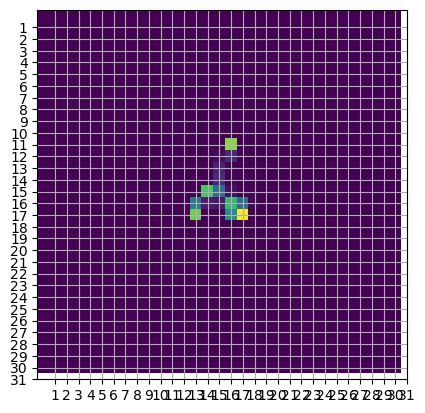

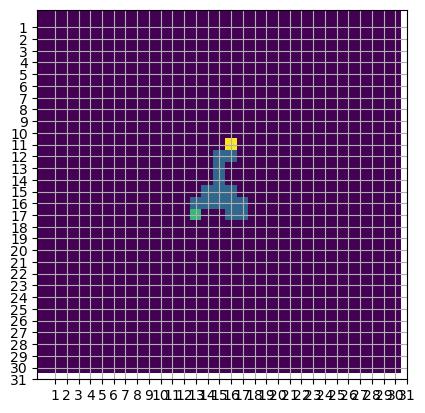

In [56]:
import matplotlib.pyplot as plt

plt.imshow(x[0][n] * 100000)
plt.xticks(np.arange(1, 32, 1))
plt.yticks(np.arange(1, 32, 1))
plt.grid()
plt.show()
plt.imshow(z[1][n] * 100000)
plt.xticks(np.arange(1, 32, 1))
plt.yticks(np.arange(1, 32, 1))
plt.grid()
plt.show()

In [116]:
x[1][n].nonzero()

(array([11, 12, 12, 13, 13, 14, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17,
        17, 17]),
 array([16, 15, 16, 15, 16, 15, 14, 15, 16, 13, 14, 15, 16, 17, 18, 13, 16,
        17, 18]))

In [117]:
z[1][n].nonzero()

(array([11, 12, 12, 13, 14, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17]),
 array([16, 15, 16, 15, 15, 14, 15, 16, 13, 14, 15, 16, 17, 13, 16, 17]))

In [61]:
len(x[1][n].nonzero()[0]), len(z[1][n].nonzero()[0])

(19, 16)

Coords that do not match (they are in x but not in z): (13, 16), (16, 18), (17, 18)

Parece que los que faltan son cuadrados con muy poca energía pero... no deberían estar vacíos entiendo

Y luego lo de que solo veo un voxel de blob en eventos de señal...

In [118]:
x[0][n][17, 18]

2.047578636467885e-05

In [119]:
z[1][n][17, 18]

0.0

Por que los voxeles de x (datos) y z (true) para la misma proyeccion no coinciden? Es decir, no hay la misma cantidad, hay voxeles de z true que están vacíos mientras que los datos no... falta algo (los que quedan con segclass 0 además luego los shifteo y se van a -1)

Por que en z la segclass sólo tiene un pixel como blob en lugar de 2 si estamos con datos doble beta??

Luego preguntar tb que es 'xy_z_mean', porque si es la media directa no debería tener valores negativos no? (z va de 0 a 1300 aprox)

In [111]:
xlabel

['xy_E_sum', 'xy_z_mean', 'yz_E_sum', 'yz_x_mean', 'zx_E_sum', 'zx_y_mean']